# Imports


In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# GeoTiff Images
import rasterio
from osgeo import gdal

# Visualisation
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import figure
from PIL import Image

# Model Building
import ultralytics
from ultralytics import YOLO
import labelme2yolo

# Others
import os
import shutil
import zipfile

%matplotlib inline

# Create Tiles

In [2]:
input_file_post = '../Datasets/Post_Event_San_Juan.tif'
input_file_pre = '../Datasets/Pre_Event_San_Juan.tif'
output_dir_post = "../Post_Event_Grids_In_TIFF"
output_dir_pre = "../Pre_Event_Grids_In_TIFF"
grid_x = 512
grid_y = 512

In [ ]:
def generate_tiles(input_file, output_dir,grid_x,grid_y):
    ds = gdal.Open(input_file)

    # Get image size and number of bands
    width = ds.RasterXSize
    height = ds.RasterYSize
    num_bands = ds.RasterCount

    # Calculate number of tiles in each dimension
    num_tiles_x = (width // grid_x)
    num_tiles_y = (height // grid_y)

    print(f"Total number of tiles: {num_tiles_x * num_tiles_y}")

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over each tile and save as a separate TIFF image
    for i in range(num_tiles_x):
        for j in range(num_tiles_y):
            x_offset = i *  grid_x
            y_offset = j *  grid_y

            tile_width = min(grid_x, width - x_offset)
            tile_height = min(grid_y, height - y_offset)

            tile = []
            for band in range(1, num_bands + 1):
                tile_data = ds.GetRasterBand(band).ReadAsArray(x_offset, y_offset, tile_width, tile_height)
                tile.append(tile_data)

            # Create output filename
            output_file = os.path.join(output_dir, f"tile_{i}_{j}.tif")
                
            # Create an output TIFF file with same CRS and band values range
            driver = gdal.GetDriverByName("GTiff")
            options = ['COMPRESS=DEFLATE', 'PREDICTOR=2', 'TILED=YES']
            out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, 
                       ds.GetRasterBand(1).DataType, options=options)
            # out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, ds.GetRasterBand(1).DataType)

            # Set the geotransform
            geotransform = list(ds.GetGeoTransform())
            geotransform[0] = geotransform[0] + x_offset * geotransform[1]
            geotransform[3] = geotransform[3] + y_offset * geotransform[5]
            out_ds.SetGeoTransform(tuple(geotransform))

            # Set the projection
            out_ds.SetProjection(ds.GetProjection())

            # Write each band to the output file
            for band in range(1, num_bands + 1):
                out_band = out_ds.GetRasterBand(band)
                out_band.WriteArray(tile[band - 1])

            # Close the output file
            out_ds = None

    print("Tiles generation completed.")

In [ ]:
generate_tiles(input_file_post, output_dir_post, grid_x, grid_y)
generate_tiles(input_file_pre, output_dir_pre, grid_x, grid_y)

# Convert tiles to jpg for labelling compatability

In [2]:
def convert_tiff_to_jpeg(input_dir,output_dir):
    # check if output_dir exists, if not create it
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        # check if file is an image (ends with .tif)
        if filename.endswith('.tif'):
            img = Image.open(os.path.join(input_dir, filename))
        
            # check if image is RGB mode, if not convert it
            if img.mode != 'RGB':
                img = img.convert('RGB')
        
            # create new filename, replace .tif with .jpg
            output_filename = os.path.splitext(filename)[0] + '.jpg'
        
            # save the image in JPEG format
            print(os.path.join(output_dir, output_filename))
            img.save(os.path.join(output_dir, output_filename), 'JPEG')
    print("Conversion from TIFF to JPEG completed.")

In [3]:
output_dir_post_jpg = "../Post_Event_Grids_In_JPG"
output_dir_pre_jpg = "../Pre_Event_Grids_In_JPG"
input_dir_post = "../Post_Event_Grids_In_TIFF"
input_dir_pre = "../Pre_Event_Grids_In_TIFF"

# convert_tiff_to_jpeg(input_dir_post, output_dir_post_jpg)
# convert_tiff_to_jpeg(input_dir_pre, output_dir_pre_jpg)

In [3]:
def rename_files(directory_path, prefix):
# Define the directory path where your files are located
    directory_path = directory_path
    
    # Get a list of all files in the directory
    files = os.listdir(directory_path)
    
    # Start the numbering from 1
    number = 0
    
    # Loop through each file in the directory
    for filename in files:
        # Check if the item is a file (not a directory)
        if os.path.isfile(os.path.join(directory_path, filename)):
            # Get the file extension
            file_extension = os.path.splitext(filename)[1]
    
            # Create the new file name with leading zeros
            new_filename = f"{prefix}{number:03}{file_extension}"
    
            # Construct the full path to the original and new files
            old_filepath = os.path.join(directory_path, filename)
            new_filepath = os.path.join(directory_path, new_filename)
    
            # Rename the file
            os.rename(old_filepath, new_filepath)
    
            # Increment the number for the next file
            number += 1
    
    print("Files renamed successfully.")

In [ ]:
rename_files(output_dir_post_jpg, "Post_Event_")
rename_files(output_dir_pre_jpg, "Pre_Event_")

# Coordinates

In [22]:
input_file_post = '../Datasets/Post_Event_San_Juan.tif'
input_file_pre = '../Datasets/Pre_Event_San_Juan.tif'
output_dir_post = "../Post_Event_Grids_In_TIFF"
output_dir_pre = "../Pre_Event_Grids_In_TIFF"
grid_x = 512
grid_y = 512

In [23]:
def load_tiff_dimensions(image_path):
    with rasterio.open(image_path) as src:
        # Get the dimensions of the TIFF file
        img_width, img_height = src.width, src.height
        
        return img_width, img_height

# Replace 'image_path.tif' with the path to your GeoTIFF file
img_width, img_height = load_tiff_dimensions(input_file_post)
print(f"TIFF dimensions: {img_width} x {img_height}")


TIFF dimensions: 38259 x 74602


In [24]:
def convert_coordinates_to_tiff_space(x, y, geographic_coverage, tiff_dimensions):
    geographic_width, geographic_height = geographic_coverage
    tiff_width, tiff_height = tiff_dimensions
    
    # Calculate the scaling factors
    x_scale = tiff_width / geographic_width
    y_scale = tiff_height / geographic_height
    
    # Convert the coordinates to TIFF space
    tiff_x = int(x * x_scale)
    tiff_y = int(y * y_scale)
    
    return tiff_x, tiff_y


In [25]:
""""
6260.256050  6022.519245
4588.879052  3660.092141
4522.345390  5585.711295
6358.288740  3940.047788
"""


pre_storm_matplot_coords = [
    convert_coordinates_to_tiff_space(6022.519245 - 300, 6260.256050 - 300, (11477.699999999999, 22380.6), (38259, 74602)),
    convert_coordinates_to_tiff_space(3660.092141 - 300, 4588.879052 - 300, (11477.699999999999, 22380.6), (38259, 74602)),
    convert_coordinates_to_tiff_space(5585.711295 -  300, 4522.345390 - 300, (11477.699999999999, 22380.6), (38259, 74602)),
    convert_coordinates_to_tiff_space(3940.047788 - 300, 6358.288740 - 300, (11477.699999999999, 22380.6), (38259, 74602))
]
                 
print(pre_storm_matplot_coords)

[(19075, 19867), (11200, 14296), (17619, 14074), (12133, 20194)]


In [26]:
post_storm_matplot_coords = []

post_storm_matplot_coords.append(convert_coordinates_to_tiff_space(10778 - 300, 6828 - 300, (11477.699999999999, 22380.6), (38259, 74602))) 
post_storm_matplot_coords.append(convert_coordinates_to_tiff_space(10915 - 300, 7884 - 300, (11477.699999999999, 22380.6), (38259, 74602))) 
post_storm_matplot_coords.append(convert_coordinates_to_tiff_space(9291 - 300, 7726 - 300, (11477.699999999999, 22380.6), (38259, 74602))) 
post_storm_matplot_coords.append(convert_coordinates_to_tiff_space(9455 - 300, 6835 - 300, (11477.699999999999, 22380.6), (38259, 74602)))

print(post_storm_matplot_coords)

[(34926, 21760), (35383, 25280), (29970, 24753), (30516, 21783)]


In [27]:
def coords_sorted(coords):
    # Sort the points by their y-coordinate (assuming y=0 is at the top of the image)
    top_two_points = sorted(coords, key=lambda x: x[1])[:2]
    bottom_two_points = sorted(coords, key=lambda x: x[1])[2:]

    # Within the top two points, sort by x to find the left and right
    top_left = min(top_two_points, key=lambda x: x[0])
    top_right = max(top_two_points, key=lambda x: x[0])

    # Do the same for the bottom two points
    bottom_left = min(bottom_two_points, key=lambda x: x[0])
    bottom_right = max(bottom_two_points, key=lambda x: x[0])

    # Now reorder the list
    return [top_left, top_right, bottom_right, bottom_left]

In [29]:
post_event_coords = coords_sorted(post_storm_matplot_coords) 
pre_event_coords = coords_sorted(pre_storm_matplot_coords)


# Show the Tiling

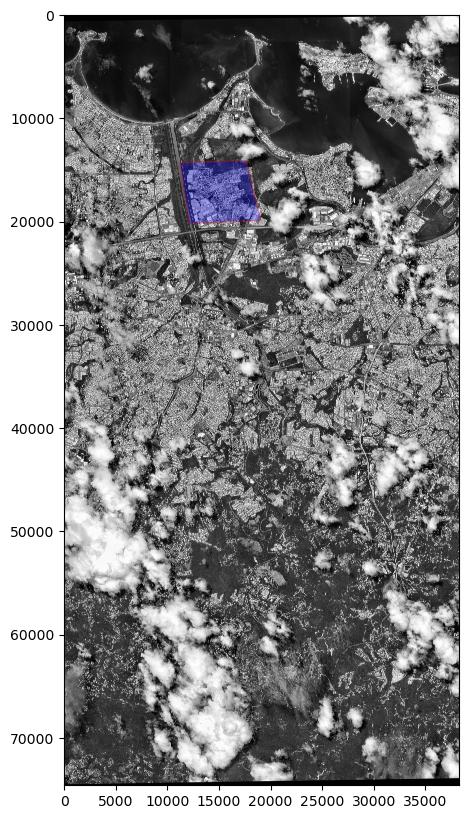

In [18]:
import rasterio
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon


# Load the pre-event image
with rasterio.open(input_file_pre) as src:
    pre_event_data = src.read(1)
    fig, ax1 = plt.subplots(figsize=(10, 10))

    # Draw a translucent polygon
    polygon = Polygon(pre_event_data, alpha=0.3, closed=True, facecolor='blue', edgecolor='r')
    ax1.add_patch(polygon)
    
    # Display the image
    ax1.imshow(pre_event_data, cmap='gray')
    plt.show()


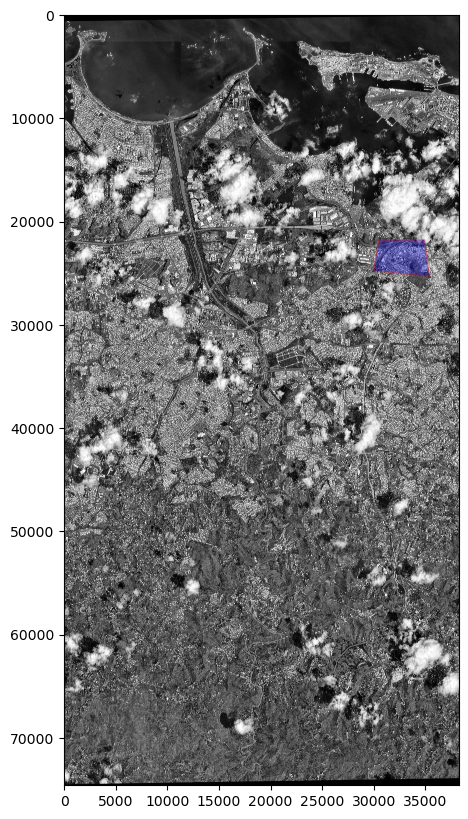

In [20]:
import rasterio
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# Load the pre-event image
with rasterio.open(input_file_post) as src:
    pre_event_data = src.read(1)
    fig, ax1 = plt.subplots(figsize=(10, 10))
    
    # Draw a translucent polygon
    polygon = Polygon(post_event_coords, alpha=0.3, closed=True, facecolor='blue', edgecolor='r')
    ax1.add_patch(polygon)

    # Display the image
    ax1.imshow(pre_event_data, cmap='gray')
    plt.show()


In [28]:
import gc

# Collect garbage
gc.collect()


0

# Save the New Tiling for Labelling

In [39]:
from osgeo import gdal, ogr
import os
import logging
logging.basicConfig(level=logging.DEBUG)

def generate_tiles(input_file, output_dir, grid_x, grid_y, polygon_coords):
    ds = gdal.Open(input_file)

    # Get image size and number of bands
    width = ds.RasterXSize
    height = ds.RasterYSize
    num_bands = ds.RasterCount

    # Create a polygon from the reordered coordinates
    ring = ogr.Geometry(ogr.wkbLinearRing)
    for coord in polygon_coords:
        ring.AddPoint(coord[0], coord[1])
    polygon = ogr.Geometry(ogr.wkbPolygon)
    polygon.AddGeometry(ring)

    # Calculate the extent of the polygon
    minX, maxX, minY, maxY = polygon.GetEnvelope()

    # Calculate number of tiles in each dimension
    num_tiles_x = (width // grid_x)
    num_tiles_y = (height // grid_y)

    print(f"Total number of tiles: {num_tiles_x * num_tiles_y}")

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over each tile and save as a separate TIFF image
    for i in range(num_tiles_x):
        for j in range(num_tiles_y):
            x_offset = i * grid_x
            y_offset = j * grid_y

            # Check if the current tile is within the extent of the polygon
            if x_offset > maxX or x_offset + grid_x < minX or y_offset > maxY or y_offset + grid_y < minY:
                continue  # Skip tiles outside the polygon extent

            tile_width = min(grid_x, width - x_offset)
            tile_height = min(grid_y, height - y_offset)
            print(f"Processing tile at ({x_offset}, {y_offset}) with dimensions ({tile_width}, {tile_height})")

            # Additional step to check if the tile intersects with the polygon
            tile_extent = ogr.Geometry(ogr.wkbPolygon)
            tile_ring = ogr.Geometry(ogr.wkbLinearRing)
            tile_ring.AddPoint(x_offset, y_offset)
            tile_ring.AddPoint(x_offset + tile_width, y_offset)
            tile_ring.AddPoint(x_offset + tile_width, y_offset + tile_height)
            tile_ring.AddPoint(x_offset, y_offset + tile_height)
            tile_ring.AddPoint(x_offset, y_offset)
            tile_extent.AddGeometry(tile_ring)
            
            if not tile_extent.Intersects(polygon):
                continue  # Skip tiles that do not intersect with the polygon

            tile = []
            for band in range(1, num_bands + 1):
                tile_data = ds.GetRasterBand(band).ReadAsArray(x_offset, y_offset, tile_width, tile_height)
                tile.append(tile_data)

            # Create output filename
            output_file = os.path.join(output_dir, f"tile_{i}_{j}.tif")
                
            # Create an output TIFF file with same CRS and band values range
            driver = gdal.GetDriverByName("GTiff")
            options = ['COMPRESS=DEFLATE', 'PREDICTOR=2', 'TILED=YES']
            out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, 
                       ds.GetRasterBand(1).DataType, options=options)

            # Set the geotransform and projection as in the input
            geotransform = list(ds.GetGeoTransform())
            geotransform[0] = geotransform[0] + x_offset * geotransform[1]
            geotransform[3] = geotransform[3] + y_offset * geotransform[5]
            out_ds.SetGeoTransform(tuple(geotransform))
            out_ds.SetProjection(ds.GetProjection())

            try:
                # Write each band to the output file
                for band in range(1, num_bands + 1):
                    out_band = out_ds.GetRasterBand(band)
                    out_band.WriteArray(tile[band - 1])
                    out_band.FlushCache()  # Ensure data is written to disk
            except Exception as e:
                logging.error(f"Failed to write tile {i}_{j}: {e}")

            # Make sure to close the dataset to flush to disk
            if out_ds is not None:
                out_ds.FlushCache()  # Ensure data is written to disk
                out_ds = None

    print("Tiles generation completed within the polygon area.")




In [41]:
input_file_post = '../Datasets/Post_Event_San_Juan.tif'
input_file_pre = '../Datasets/Pre_Event_San_Juan.tif'
output_dir_post = "../Post_Event_Grids_In_TIFF"
output_dir_pre = "../Pre_Event_Grids_In_TIFF"
grid_x = 512
grid_y = 512
tile_labelling_output_dir_post = "../Post_Event_Grids_In_TIFF_Kacper_Selections3"
tile_labelling_output_dir_pre = "../Pre_Event_Grids_In_TIFF_Kacper_Selections3"


# Call the function with the reordered coordinates
generate_tiles(input_file_post, tile_labelling_output_dir_post, grid_x, grid_y, post_event_coords)
generate_tiles(input_file_pre, tile_labelling_output_dir_pre, grid_x, grid_y, pre_event_coords)

Total number of tiles: 10730
Processing tile at (29696, 21504) with dimensions (512, 512)
Processing tile at (29696, 22016) with dimensions (512, 512)
Processing tile at (29696, 22528) with dimensions (512, 512)
Processing tile at (29696, 23040) with dimensions (512, 512)
Processing tile at (29696, 23552) with dimensions (512, 512)
Processing tile at (29696, 24064) with dimensions (512, 512)
Processing tile at (29696, 24576) with dimensions (512, 512)
Processing tile at (29696, 25088) with dimensions (512, 512)
Processing tile at (30208, 21504) with dimensions (512, 512)
Processing tile at (30208, 22016) with dimensions (512, 512)
Processing tile at (30208, 22528) with dimensions (512, 512)
Processing tile at (30208, 23040) with dimensions (512, 512)
Processing tile at (30208, 23552) with dimensions (512, 512)
Processing tile at (30208, 24064) with dimensions (512, 512)
Processing tile at (30208, 24576) with dimensions (512, 512)
Processing tile at (30208, 25088) with dimensions (512, 

In [19]:
tile_labelling_output_dir_post_jpg = "../Post_Event_Grids_In_JPG_Kacper_Selections"
tile_labelling_output_dir_pre_jpg = "../Pre_Event_Grids_In_JPG_Kacper_Selections"

convert_tiff_to_jpeg(tile_labelling_output_dir_post, tile_labelling_output_dir_post_jpg)
convert_tiff_to_jpeg(tile_labelling_output_dir_pre, tile_labelling_output_dir_pre_jpg)

../Post_Event_Grids_In_JPG_Kacper_Selections\tile_29970_24753.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_30516_21783.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_34926_21760.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_35383_25280.jpg
Conversion from TIFF to JPEG completed.
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_11200_14296.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_12133_20194.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_17619_14074.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_19075_19867.jpg
Conversion from TIFF to JPEG completed.
